# Budowanie, trenowanie i testowanie modelu

In [8]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path

Wczytanie odpowiednich danych

In [2]:
df = pd.read_csv('data2/df_training.csv')
ds = df.to_numpy()

# Wstępne Przetwarzanie Danych

Rozdzielenie danych na wejściowe i wyjściowe

In [3]:
x_ds = ds[:, 0:17] # 17 danych - 3*3xyz + 6*dJ + 2*dG
y_ds = ds[:, 17:]  # 8  danych - 6*pred_dJ + 2*pred_dG
print(x_ds.shape)
print(y_ds.shape)
print(x_ds[0])
print(y_ds[0])

(8060, 17)
(8060, 8)
[ 0.88793552 -0.54713482 -1.7142334   0.24522633  0.16836209 -0.09461975
  0.06873373 -0.36582538 -0.40885925  3.423105    1.230969    1.932432
  1.527801    1.58762     2.663374    0.603365    0.905047  ]
[-0.000294  0.000588  0.000294 -0.000527  0.001726 -0.002205 -0.005113
  0.      ]


Rozdzielenie danych na treningowe i testowe

In [4]:
rand = np.random.permutation(len(x_ds))
x_ds_shuffled = x_ds[rand]
y_ds_shuffled = y_ds[rand]

split_idx = int(len(x_ds_shuffled) * 0.9)
x_train = x_ds_shuffled[:split_idx]
x_test = x_ds_shuffled[split_idx:]
y_train = y_ds_shuffled[:split_idx]
y_test = y_ds_shuffled[split_idx:]

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

print(x_train[0])
print(x_test[0])

(7254, 17)
(806, 17)
(7254, 8)
(806, 8)
[-37.70499885 -53.56753924  27.9793396  -40.26935324 -53.91886672
  38.87818909 -42.97090603 -55.27008523  37.54125977   3.225774
   1.206826     2.21527      1.265682     1.581244     2.870893
   0.189191     1.360128  ]
[  8.90150716 -52.27783632  10.25125122  -4.1750519  -50.79906234
  27.14819336  -6.34982083 -48.64001908  16.55329895   3.747278
   1.618386     1.9255       1.139464     1.561158     3.772922
   0.608478     0.899934  ]


Normalizowanie danych

In [5]:
#"""
x_train_mean = np.mean(x_train, axis=0)
x_train_std = np.std(x_train, axis=0)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

print(x_train[0])
print(x_test[0])
#""";

[-0.54755326 -0.98468624  1.18042844 -0.53455997 -0.9098969   1.26581007
 -0.62532375 -0.94350902  1.43727704 -0.67199834 -2.29768936  1.56051148
  0.71317419 -0.21075581  0.17983017 -1.06013254  1.0713623 ]
[ 0.02462451 -0.95888996  0.3806872  -0.11773749 -0.85212801  0.85712268
 -0.15913072 -0.82102822  0.60842193  1.09042386 -0.85952506  0.72829156
 -0.10461834 -1.86358774  1.7346302   0.63068819 -0.63204432]


Sprawdzenie histogramów danych

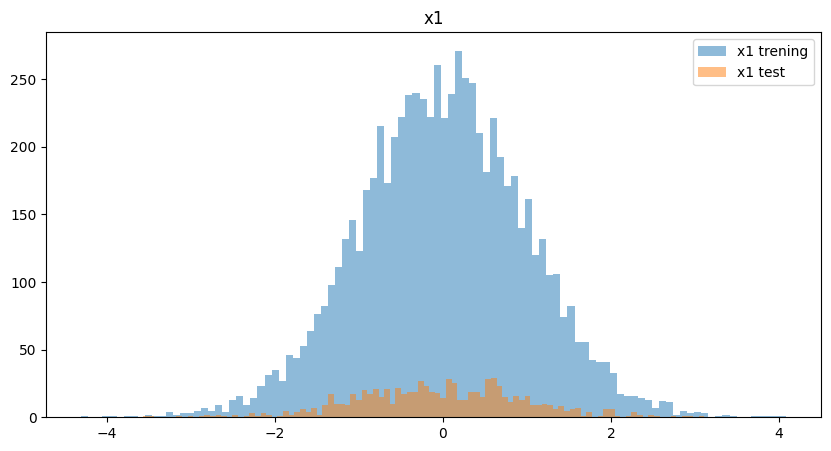

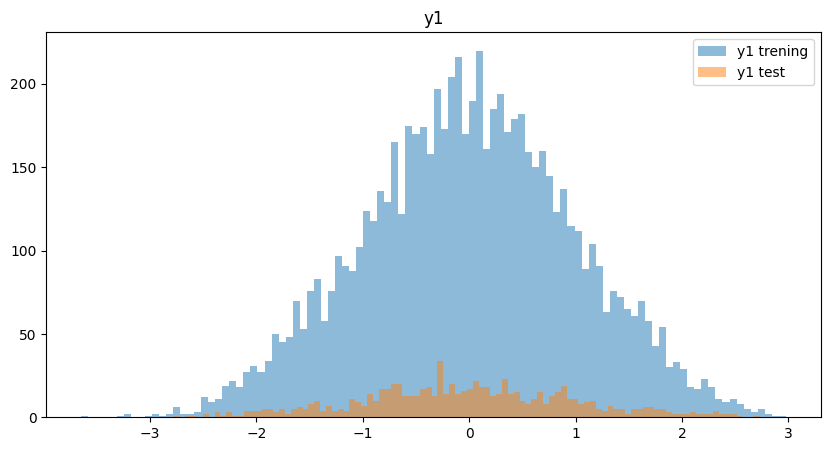

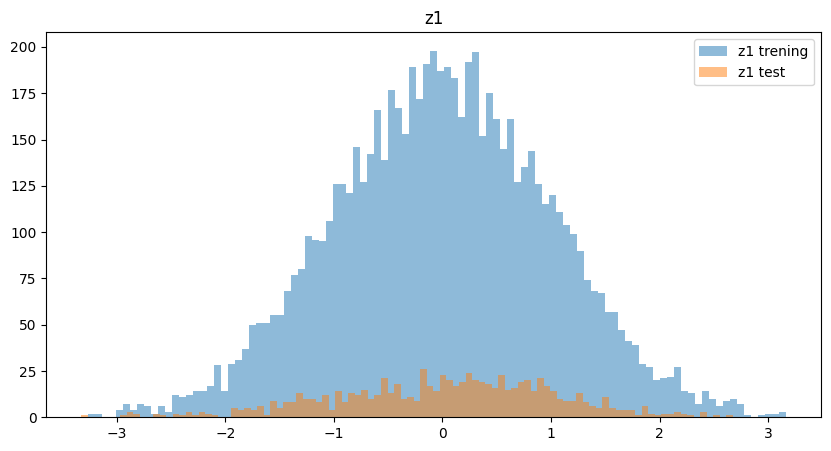

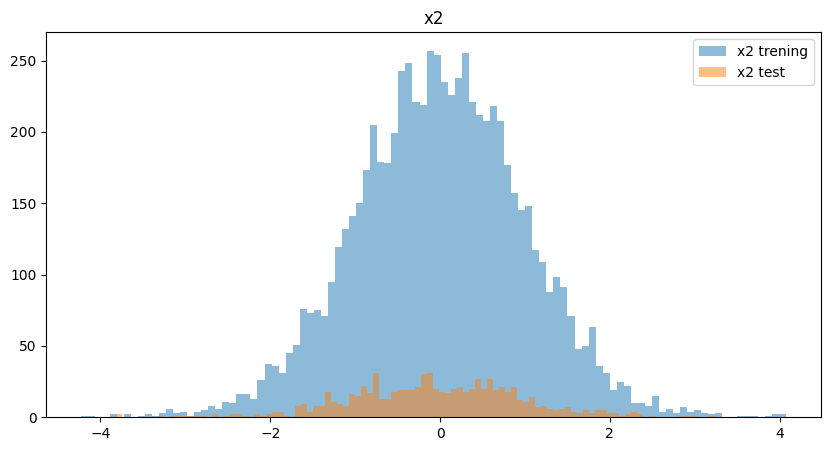

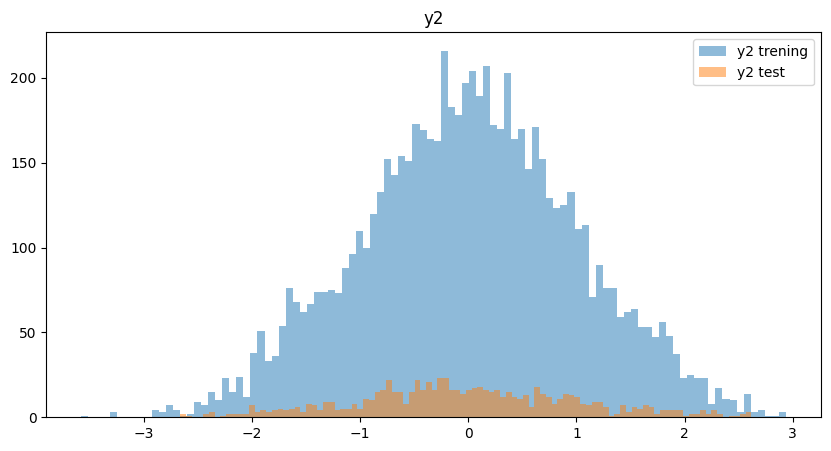

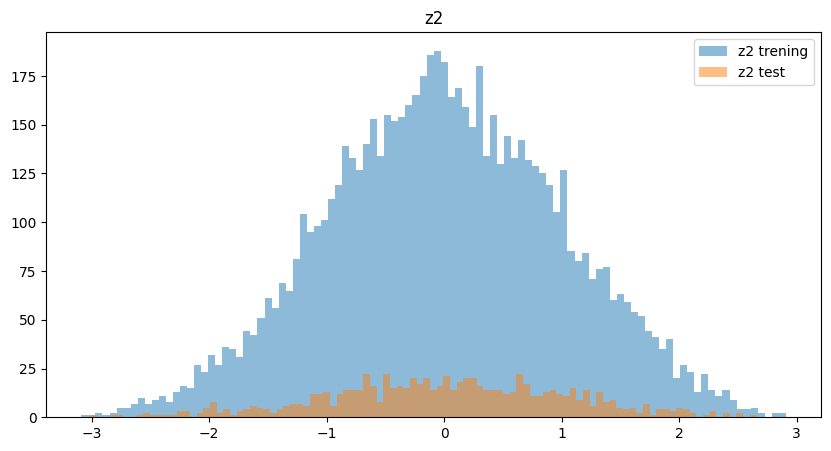

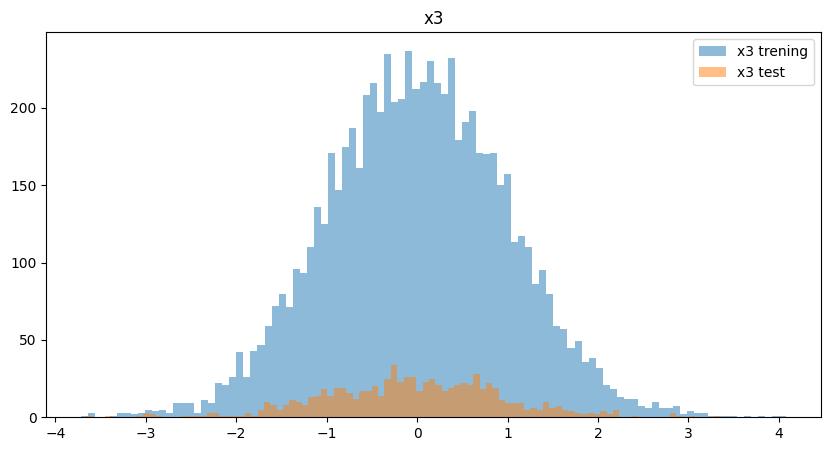

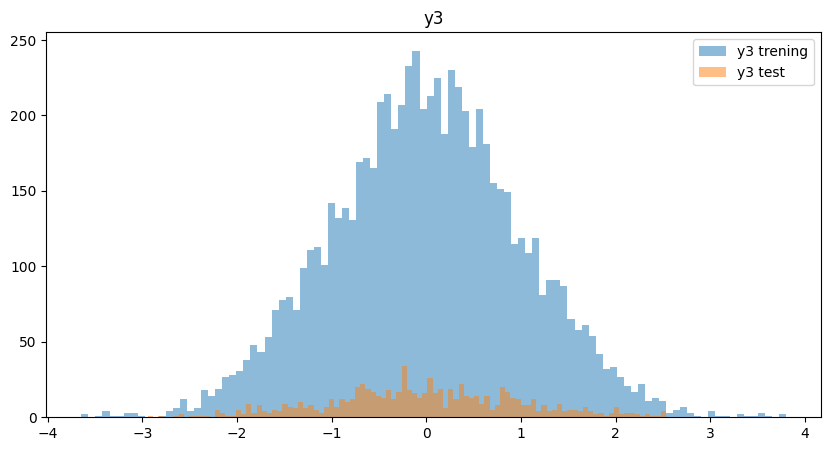

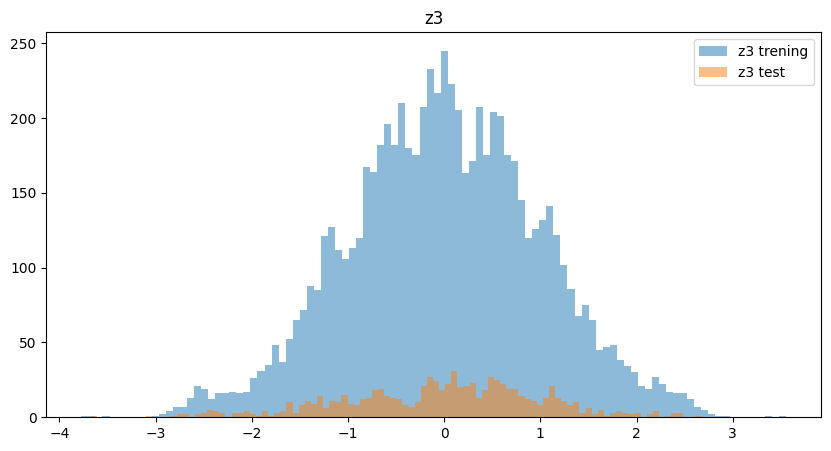

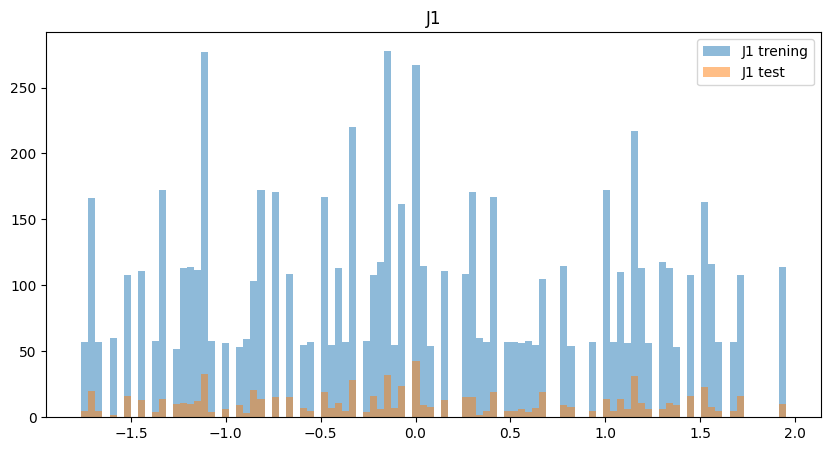

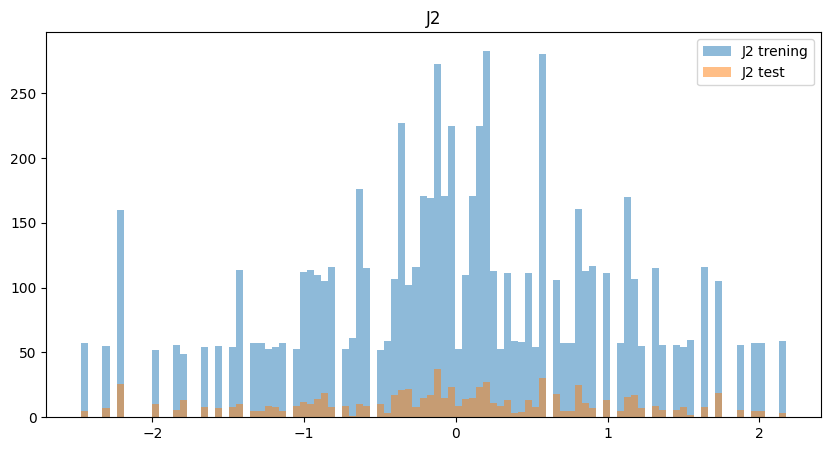

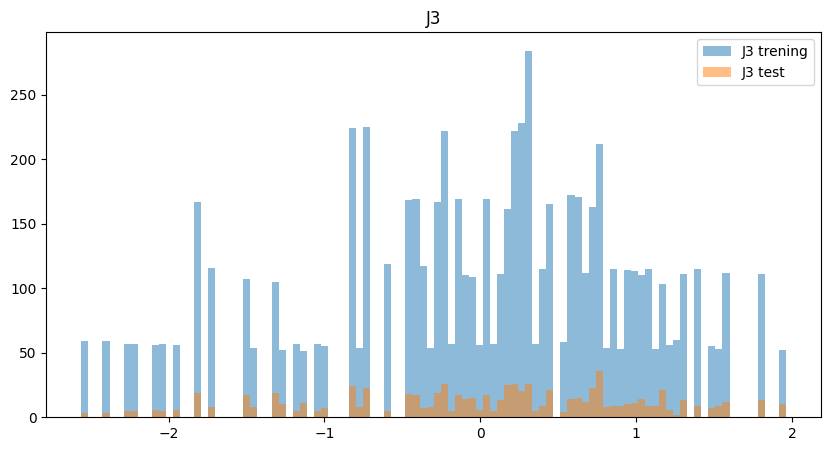

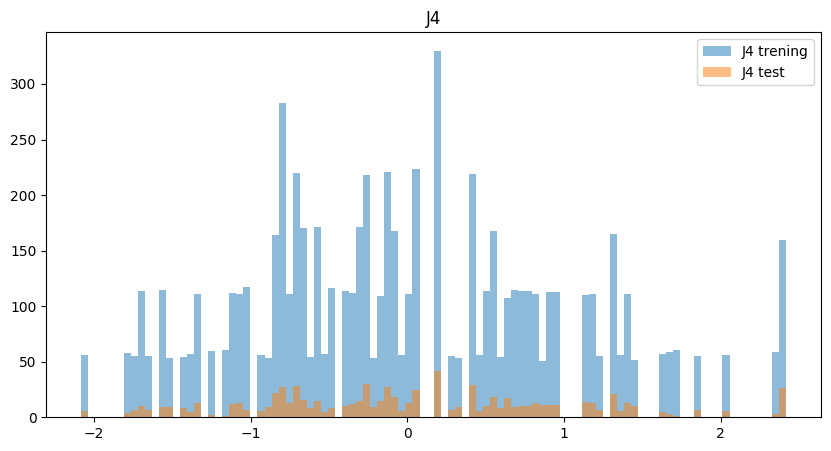

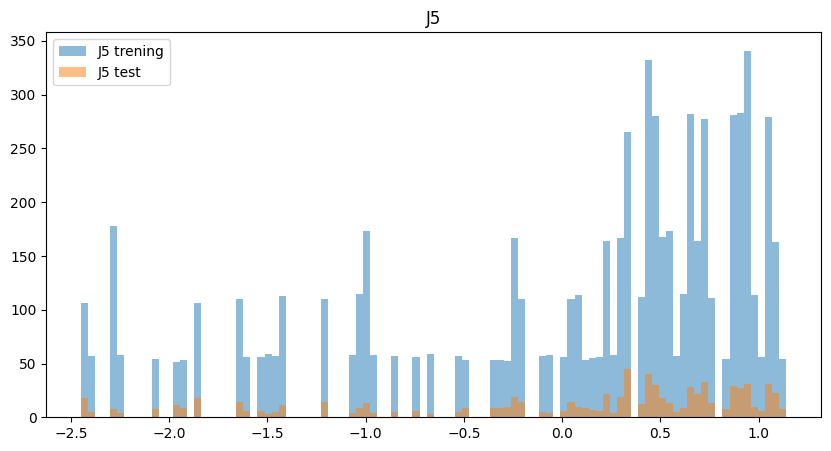

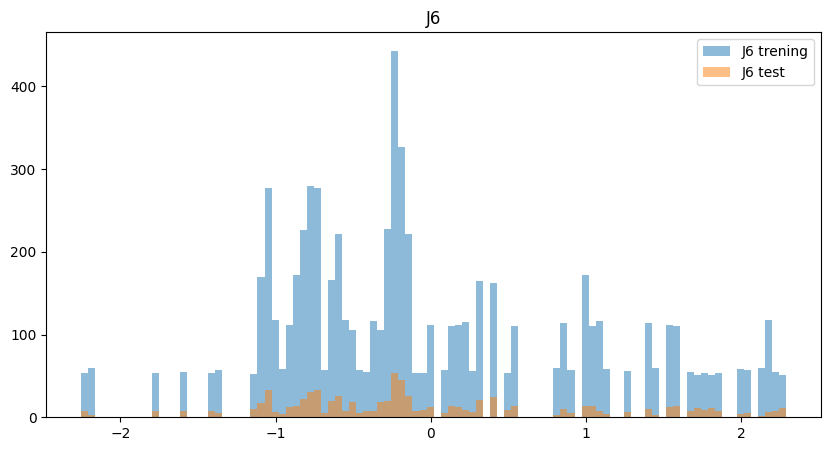

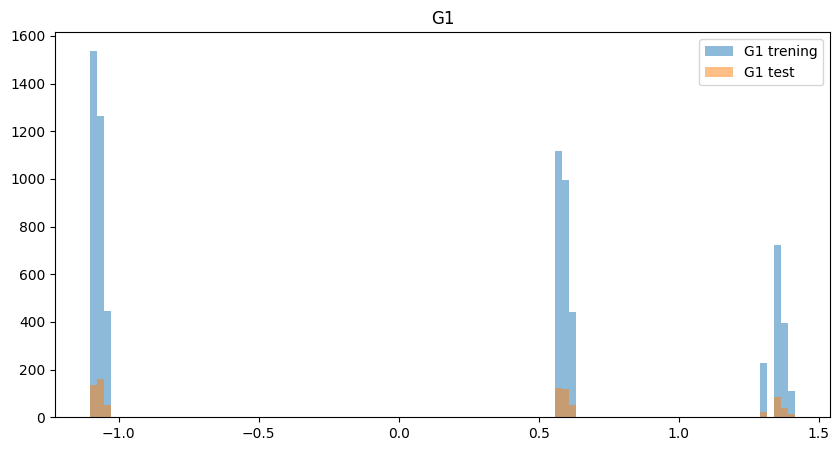

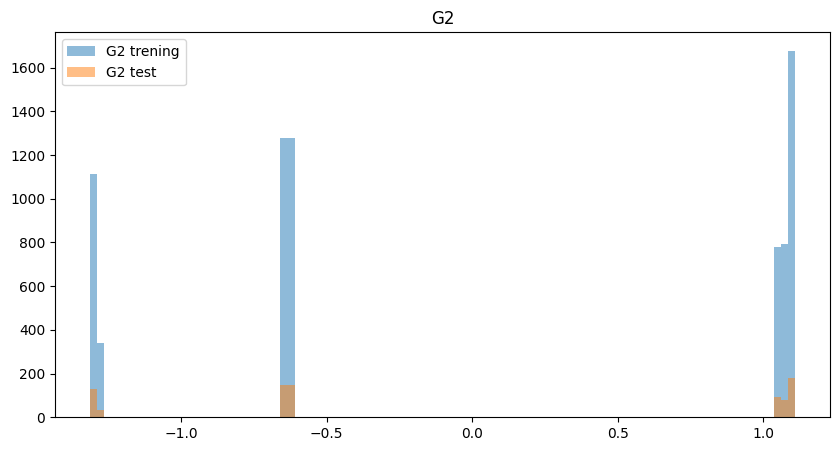

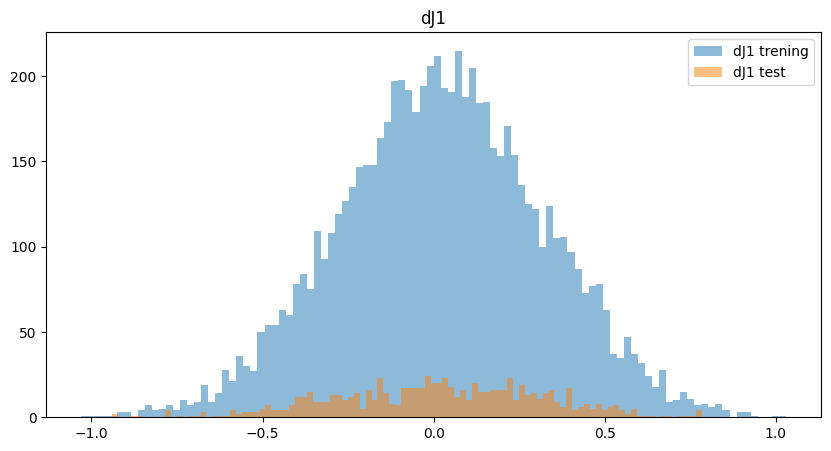

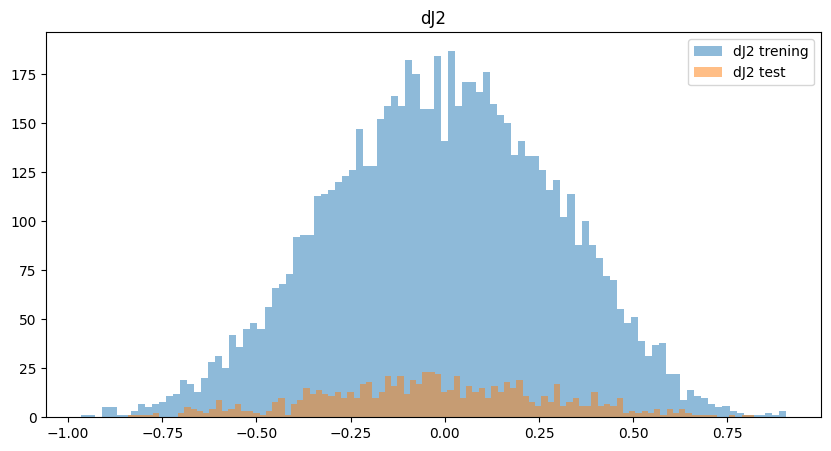

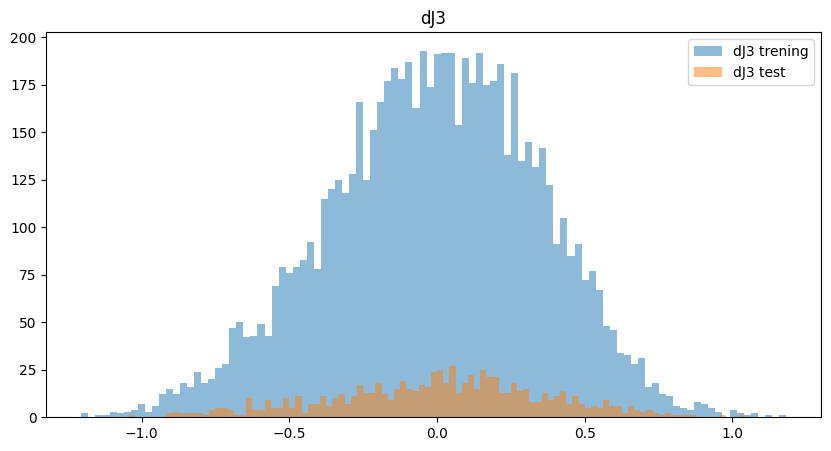

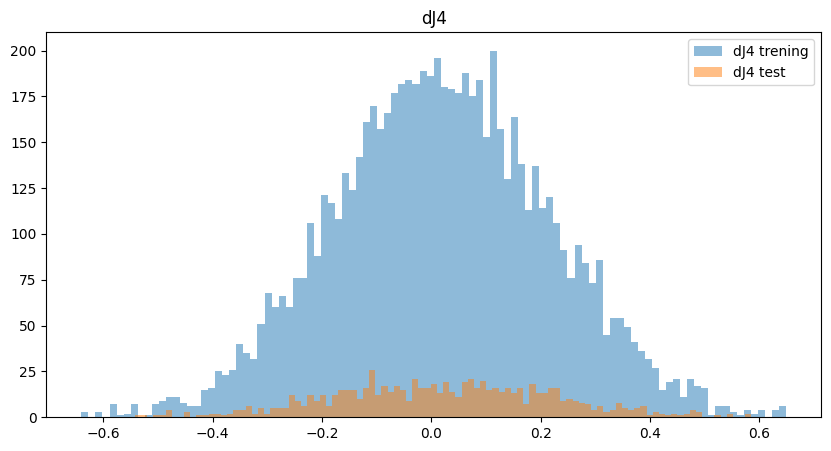

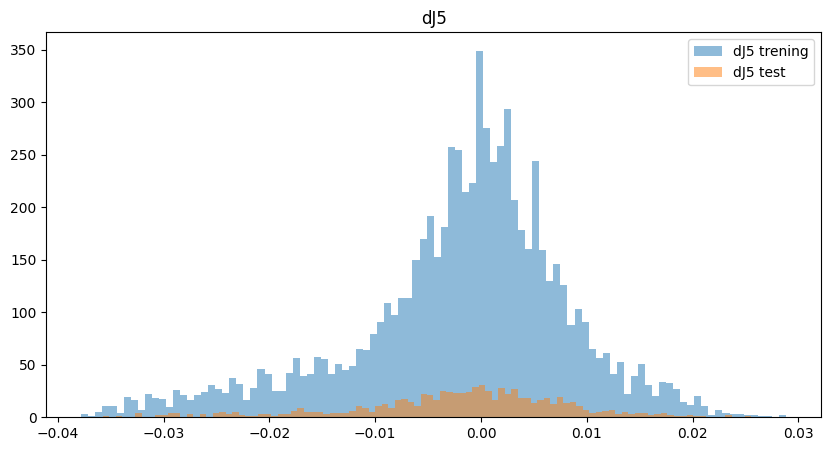

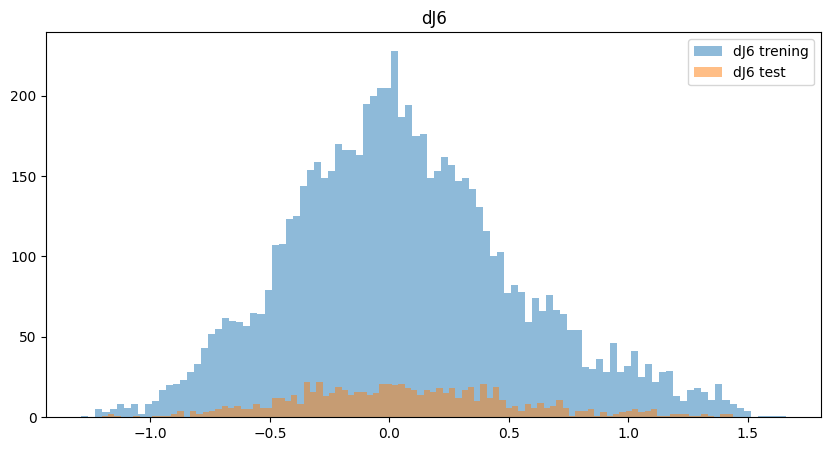

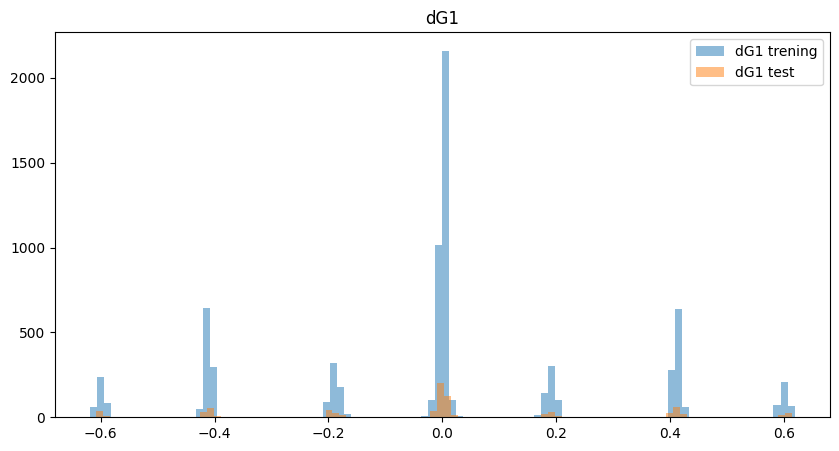

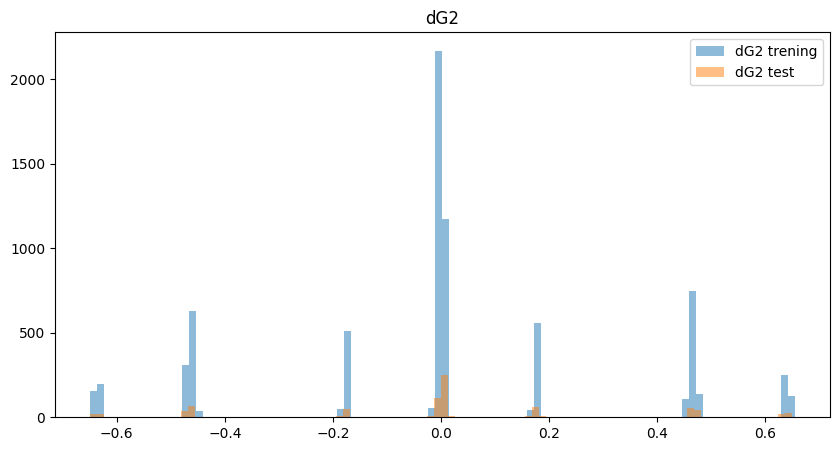

In [6]:
for i in range(x_train.shape[1]):
  plt.figure(figsize=(10, 5))
  plt.hist(x_train[:, i], bins=100, alpha=0.5, label=str(df.columns[i] + ' trening'))
  plt.hist(x_test[:, i], bins=100, alpha=0.5, label=str(df.columns[i] + ' test'))
  plt.title(df.columns[i])
  # plt.xlabel(df.columns[i])
  # plt.ylabel('Frequency')
  plt.legend()
  plt.show()

for i in range(y_train.shape[1]):
  plt.figure(figsize=(10, 5))
  plt.hist(y_train[:, i], bins=100, alpha=0.5, label=str(df.columns[i+x_train.shape[1]] + ' trening'))
  plt.hist(y_test[:, i], bins=100, alpha=0.5, label=str(df.columns[i+x_train.shape[1]] + ' test'))
  plt.title(df.columns[i+x_train.shape[1]])
  # plt.xlabel(df.columns[i+x_train.shape[1]])
  # plt.ylabel('Frequency')
  plt.legend()
  plt.show()

# Tworzenie i Konfiguracja Modelu

Podstawowe parametry modelu

In [ ]:
OUTPUTS_PATH = Path("data2/outputs")
MODEL_PATH = Path("data2/model")

OUTPUTS_PATH.mkdir(parents=True, exist_ok=True)
MODEL_PATH.mkdir(parents=True, exist_ok=True)

input_shape = x_train.shape[-1]
num_labels = y_train.shape[-1]
print(input_shape, num_labels)

Lista callback do uczenia

In [15]:
callbacks_list = [
  tf.keras.callbacks.ModelCheckpoint(
    filepath=str(MODEL_PATH)+'/saved_model.keras',
    monitor='val_loss',
    save_best_only=True
  ),
  tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=6,
    verbose=True
  ),
  tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
  )]

## Wariant 1 - Budowanie modelu ręcznie

Parametry modelu

In [ ]:
neurons = 320
dropout = 0.1

17 8


In [ ]:
"""
inputs = tf.keras.Input(shape=(input_shape,))

# augmentacja
#x = tf.keras.layers.GaussianNoise(0.1)(inputs)

x = tf.keras.layers.Dense(neurons, activation='relu', activity_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.Dropout(dropout/2)(x)

# Pierwszy blok residual
x_skip = x
x = tf.keras.layers.Dense(neurons*2, activation='relu', activity_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(neurons, activation='relu', activity_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([x, x_skip])

# Drugi blok residual
x_skip = x
x = tf.keras.layers.Dense(neurons*2, activation='relu', activity_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(neurons, activation='relu', activity_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([x, x_skip])

outputs = tf.keras.layers.Dense(num_labels)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()
#""";

## Wariant 2 - Budowanie modelu za pomocą tunera

In [ ]:
"""
import keras_tuner as kt

input_shape = x_train.shape[-1]
num_labels = y_train.shape[-1]

def build_model(hp):
    
    num_blocks = hp.Int('num_blocks', min_value=4, max_value=8, step=1)
    neurons = hp.Int('neurons', min_value=64, max_value=640, step=64)
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    
    inputs = tf.keras.Input(shape=(input_shape,))
    x = inputs
    x = tf.keras.layers.Dense(neurons, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    for i in range(num_blocks):
        x_skip = x
        x = tf.keras.layers.Dense(neurons*2, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Dense(neurons, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Add()([x, x_skip])
    
    outputs = tf.keras.layers.Dense(num_labels)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=16,
    executions_per_trial=1,
    #directory='ktuner_dir',
    project_name='diff_pred_tuning'
)

tuner.search(x_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=256,
    callbacks=callbacks_list)
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best number of blocks:", best_hp.get('num_blocks'))
print("Best neurons:", best_hp.get('neurons'))
print("Best learning rate:", best_hp.get('learning_rate'))
#""";

Trial 16 Complete [00h 06m 34s]
val_loss: 0.023840406909585

Best val_loss So Far: 0.013031317852437496
Total elapsed time: 02h 04m 31s
Best number of blocks: 8
Best neurons: 192
Best learning rate: 0.008437021601381293


Tworzenie modelu

In [ ]:
#model = build_model(best_hp)
#model.save(str(MODEL_PATH)+"/new_model_tuned.keras")

# Proces Uczenia

Odczytanie już utworzonego modelu

In [21]:
model = tf.keras.models.load_model(str(MODEL_PATH)+"/model_tuned.keras")

/home/ruszczka/projekty/mag/.GDSAM/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 142 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
"""
base_learning_rate = 1e-2
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    base_learning_rate,
    decay_steps=2318,
    decay_rate=0.8,
    staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss= tf.keras.losses.MeanSquaredError(),
              metrics = [tf.keras.metrics.RootMeanSquaredError()])
#""";

Proces uczenia

In [22]:
history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=256,
    callbacks=callbacks_list
)

Epoch 1/300


23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 361ms/step - loss: 20.7243 - root_mean_squared_error: 4.3492 - val_loss: 4376.0322 - val_root_mean_squared_error: 66.1516 - learning_rate: 0.0084
Epoch 2/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4459 - root_mean_squared_error: 0.6662 - val_loss: 76.9856 - val_root_mean_squared_error: 8.7741 - learning_rate: 0.0084
Epoch 3/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2257 - root_mean_squared_error: 0.4750 - val_loss: 4.4980 - val_root_mean_squared_error: 2.1208 - learning_rate: 0.0084
Epoch 4/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1685 - root_mean_squared_error: 0.4105 - val_loss: 0.9636 - val_root_mean_squared_error: 0.9816 - learning_rate: 0.0084
Epoch 5/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1534 - root_mean_squared_error: 0.3916 - val_loss: 0.4294 - val_root_mean_squared_error: 0.6553 - learning_rate: 0.0084
Epoch 6/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1340 - root_mean_squared_error: 

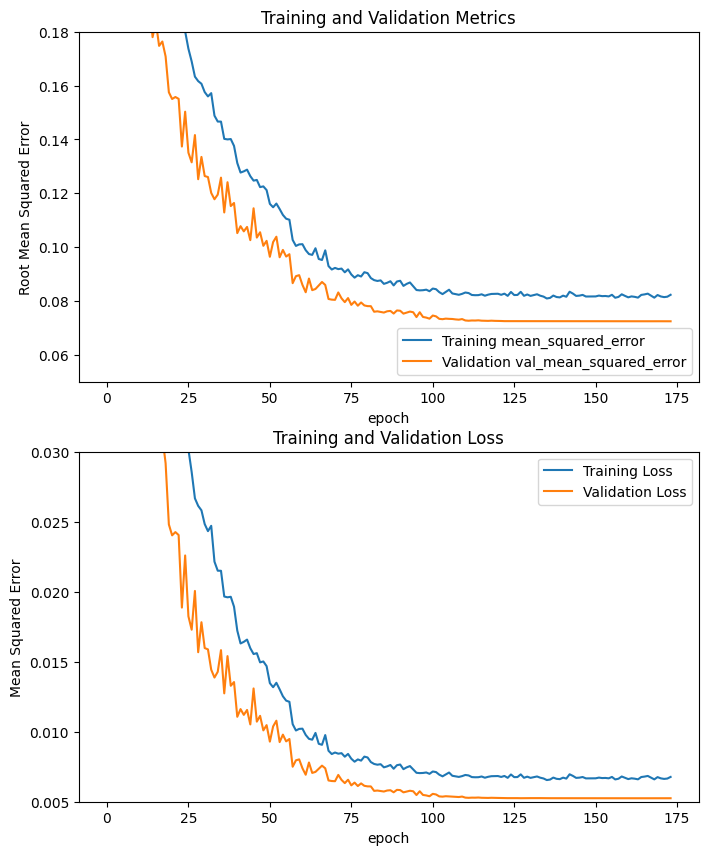

In [29]:
root_mean_squared_error = history.history['root_mean_squared_error']
val_root_mean_squared_error = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
plt.plot(root_mean_squared_error, label='Training mean_squared_error')
plt.plot(val_root_mean_squared_error, label='Validation val_mean_squared_error')
plt.legend(loc='lower right')
plt.ylabel('Root Mean Squared Error')
plt.ylim(0.05,0.18)
plt.title('Training and Validation Metrics')
plt.xlabel('epoch')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Mean Squared Error')
plt.ylim(0.005,0.03)
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(str(OUTPUTS_PATH)+'/fig.png')

In [25]:
model.evaluate(x=x_test, y=y_test, batch_size=256, verbose=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0052 - root_mean_squared_error: 0.0722


[0.005092520732432604, 0.07136189937591553]

## Testowanie uzyskanego modelu

Zapisanie wyników predykcji

In [31]:
result = model.predict(x=x_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step


Wyświetlenie błędów na poszczególnych przegubach

In [ ]:
diff_test = np.rad2deg(np.mean(np.abs(result-y_test), axis=0))

joints_error_dict = dict(zip(df.columns[17:], diff_test))
for joint, error in joints_error_dict.items():
    print(f"{joint}: {error:.2f} stopni")

dJ1: 1.40 stopni
dJ2: 1.43 stopni
dJ3: 2.53 stopni
dJ4: 1.82 stopni
dJ5: 0.76 stopni
dJ6: 5.69 stopni
dG1: 3.29 stopni
dG2: 3.43 stopni
Średnia: 2.55 stopni
Mediana: 1.53 stopni


Wyświetlenie średniej i mediane błędu absolutnego

In [ ]:
mean_test = np.rad2deg(np.mean(np.abs(result-y_test)))
median_test = np.rad2deg(np.median(np.abs(result-y_test)))

print(f"Średnia: {mean_test:.2f} stopni")
print(f"Mediana: {median_test:.2f} stopni")

## Zapisanie wyników do pliku .csv

In [34]:
cols = [ 'J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'G1', 'G2',
        'dJ1', 'dJ2', 'dJ3', 'dJ4', 'dJ5', 'dJ6', 'dG1', 'dG2',
        'pred_dJ1', 'pred_dJ2', 'pred_dJ3', 'pred_dJ4', 'pred_dJ5', 'pred_dJ6', 'pred_dG1', 'pred_dG2']

In [35]:
print(result.shape)
print(x_test[:,9:].shape)
print(y_test.shape)

(806, 8)
(806, 8)
(806, 8)


Zapisanie wyników do testowania na robocie

In [37]:
wyniki = pd.concat([pd.DataFrame(x_test[:,9:]*x_train_std[9:]+x_train_mean[9:], columns=cols[:8]),  # Pozycja początkowa
                    pd.DataFrame(y_test, columns=cols[8:16]),                                       # Różnica faktyczna
                    pd.DataFrame(result, columns=cols[16:])], axis=1)                               # Różnica przewidywana
wyniki.to_csv(str(OUTPUTS_PATH)+"/wyniki.csv", index=False, header=True)

In [38]:
wyniki.head(5)

,J1,J2,J3,J4,J5,J6,G1,G2,dJ1,dJ2,...,dG1,dG2,pred_dJ1,pred_dJ2,pred_dJ3,pred_dJ4,pred_dJ5,pred_dJ6,pred_dG1,pred_dG2
0,3.747278,1.618386,1.925500,1.139464,1.561158,3.772922,0.608478,0.899934,0.163653,-0.284757,...,0.015340,0.005113,0.164711,-0.280066,0.203094,0.067482,-0.001365,0.524268,-0.016461,0.002519
1,3.915493,1.847829,1.794312,1.053609,1.592701,2.421437,0.593138,0.894821,0.486144,0.095607,...,0.409061,-0.465307,0.474200,0.083149,-0.155919,0.059839,-0.029471,-0.177610,0.227621,-0.296595
2,3.541860,1.595066,1.908211,1.181744,1.566575,3.510084,0.598252,0.894821,0.256835,-0.204771,...,0.414175,-0.475533,0.235537,-0.159439,0.131885,-0.013053,-0.016904,0.862853,0.281670,-0.355879
3,3.551435,1.986928,1.805257,0.891007,1.570937,3.353474,0.194304,1.360128,0.084411,-0.112763,...,-0.403948,0.465307,0.081245,-0.095861,0.459085,-0.387474,0.012967,-0.101674,-0.479833,0.536374
4,3.422946,1.230973,1.932269,1.528280,1.587620,2.663326,0.802782,0.720970,0.266958,-0.601274,...,0.613591,-0.634044,0.285858,-0.575350,0.161138,0.427484,-0.012025,0.345448,0.625257,-0.655319


In [39]:
np.sum(np.abs(np.rad2deg(wyniki["dJ1"])-np.rad2deg(wyniki["pred_dJ1"]))<1)

np.int64(368)